In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from learntools.core import *

iowa_file_path = '../input/train.csv'
iowa_test_file_path = '../input/test.csv'
train_data = pd.read_csv(iowa_file_path)
test_data = pd.read_csv(iowa_test_file_path)

y = train_data.SalePrice
train_features = train_data.drop(['Id', 'SalePrice'], axis = 1)
test_data_no_id = test_data.drop(['Id'], axis = 1)

# Missing and categorical values

In [2]:
# fill in missing numeric values
from sklearn.impute import SimpleImputer

# impute
train_data_num = train_features.select_dtypes(exclude=['object'])
test_data_num = test_data_no_id.select_dtypes(exclude=['object'])
imputer = SimpleImputer()
train_num_cleaned = imputer.fit_transform(train_data_num)
test_num_cleaned = imputer.transform(test_data_num)

# columns rename after imputing
train_num_cleaned = pd.DataFrame(train_num_cleaned)
test_num_cleaned = pd.DataFrame(test_num_cleaned)
train_num_cleaned.columns = train_data_num.columns
test_num_cleaned.columns = test_data_num.columns

In [3]:
# string columns: transform to dummies
train_data_str = train_data.select_dtypes(include=['object'])
test_data_str = test_data_no_id.select_dtypes(include=['object'])
train_str_dummy = pd.get_dummies(train_data_str)
test_str_dummy = pd.get_dummies(test_data_str)
train_dummy, test_dummy = train_str_dummy.align(test_str_dummy, 
                                                join = 'left', 
                                                axis = 1)

In [4]:
# convert numpy dummy tables to pandas DataFrame
train_num_cleaned = pd.DataFrame(train_num_cleaned)
test_num_cleaned = pd.DataFrame(test_num_cleaned)

In [5]:
# joining numeric (after imputing) and string (converted to dummy) data
train_all_clean = pd.concat([train_num_cleaned, train_dummy], axis = 1)
test_all_clean = pd.concat([test_num_cleaned, test_dummy], axis = 1)

In [6]:
# detect NaN in already cleaned test data 
# (there could be completely empty columns in test data)
cols_with_missing = [col for col in test_all_clean.columns
                                if test_all_clean[col].isnull().any()]
for col in cols_with_missing:
    print(col, test_all_clean[col].isnull().any())

Utilities_NoSeWa True
Condition2_RRAe True
Condition2_RRAn True
Condition2_RRNn True
HouseStyle_2.5Fin True
RoofMatl_ClyTile True
RoofMatl_Membran True
RoofMatl_Metal True
RoofMatl_Roll True
Exterior1st_ImStucc True
Exterior1st_Stone True
Exterior2nd_Other True
Heating_Floor True
Heating_OthW True
Electrical_Mix True
GarageQual_Ex True
PoolQC_Fa True
MiscFeature_TenC True


In [7]:
# since there are empty columns in test we need to drop them in train and test data
train_all_clean_no_nan = train_all_clean.drop(cols_with_missing, axis = 1)
test_all_clean_no_nan = test_all_clean.drop(cols_with_missing, axis = 1)

# XGBoost training and validation

In [8]:
train_X, val_X, train_y, val_y = train_test_split(train_all_clean_no_nan, y, random_state=1)

# default XGBoost
xgb_model = XGBRegressor(random_state = 1)
xgb_model.fit(train_X, train_y, verbose = False)
xgb_predictions = xgb_model.predict(val_X)
xgb_mae = mean_absolute_error(val_y, xgb_predictions)
print("XGBoost MAE default: {:,.0f}".format(xgb_mae))

# fine tuned XGBoost
xgb_model = XGBRegressor(n_estimators = 1000, learning_rate=0.05, random_state = 1)
xgb_model.fit(train_X, train_y, early_stopping_rounds = 25, eval_set = [(val_X, val_y)], verbose = False)
# with verbose = True we have the best iteration on step 757 => n_estimators = 757

XGBoost MAE default: 14,967


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [9]:
xgb_predictions = xgb_model.predict(val_X)
xgb_mae = mean_absolute_error(val_y, xgb_predictions)
print("XGBoost MAE default: {:,.0f}".format(xgb_mae))

XGBoost MAE default: 14,315


# XGBoost Model (on all training data)

In [10]:
# To improve accuracy, create a new Random Forest model which you will train on all training data
xgb_model_on_full_data = xgb_model = XGBRegressor(n_estimators = 757, learning_rate=0.05)
xgb_model_on_full_data.fit(train_all_clean_no_nan, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=757,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# Partial dependencies plots

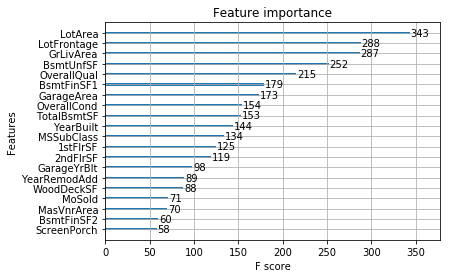

In [11]:
from xgboost import plot_importance

plot_importance(xgb_model_on_full_data, max_num_features = 20)

# Make Predictions

In [12]:
test_X = test_all_clean_no_nan
test_preds = xgb_model_on_full_data.predict(test_X)

In [13]:
output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': test_preds})
output.to_csv('submission.csv', index=False)